In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import matplotlib.colors
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures

from numba import njit,prange
from numba.typed import List

In [2]:
full_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[41.,50.],'lonlim':[0.,20.]}
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
EUROCORDEX_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[42.5,49],'lonlim':[2.5,16.5]}

imin = 15 ; imax = -23
jmin = 10 ; jmax = -6

ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/MARgrid_EUy.nc')

lon_ = ds.LON.data[jmin:jmax,imin:imax]
lat_ = ds.LAT.data[jmin:jmax,imin:imax]
H_ = ds.SH.data[jmin:jmax,imin:imax]

In [3]:
# simulation = '/bettik/philinat/EURO4M_APGD/APGD_*.nc'
# simulation = '/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.'

# simulation = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/HIST/daily/ICE.MPI-ESM_HIST.EUy.'
simulation = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP585/daily/ICE.MPI-ESM_SSP585.EUy.'

# simulation = '/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.'
# simulation = '/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.'

In [4]:
ds_rr = xr.open_mfdataset(simulation+'MBrr.*.nc')
ds_sf = xr.open_mfdataset(simulation+'MBsf.*.nc')
dates = ds_rr.MBrr.time#.dt.month
P = np.array(ds_rr.MBrr.data[:,jmin:jmax,imin:imax] + ds_sf.MBsf.data[:,jmin:jmax,imin:imax])
print(np.shape(P))

(31411, 110, 163)


In [6]:
U = np.array(xr.open_mfdataset(simulation+'UUz.*.nc').UUz.data[:,2,jmin:jmax,imin:imax])
V = np.array(xr.open_mfdataset(simulation+'VVz.*.nc').VVz.data[:,2,jmin:jmax,imin:imax])

In [7]:
centroids_P,centroids_SLP,centroids_U,centroids_V = np.load('/home/philinat/Stage-M2/saved_clustering/centroids_data.npy')

dist_centroids = np.zeros((len(P),9,2))
for i in range(len(P)):
    for j in range(9):
        dist_centroids[i,j,0] = (1- np.sum(P[i]*centroids_P[j]) / np.sqrt(np.sum(P[i]**2)*np.sum(centroids_P[j]**2)))
        dist_centroids[i,j,1] = (1- np.sum(U[i]*centroids_U[j]+V[i]*centroids_V[j]) / np.sqrt(np.sum(U[i]**2+V[i]**2)*np.sum(centroids_U[j]**2+centroids_V[j]**2)))/2

In [8]:
np_dates = np.transpose(np.array([dates.dt.year,dates.dt.month,dates.dt.day]))

# np.save('/home/philinat/Stage-M2/saved_dist_centroids/ERA5.npy',dist_centroids)
# np.save('/home/philinat/Stage-M2/saved_dist_centroids/dates_ERA5.npy',np_dates)

# np.save('/home/philinat/Stage-M2/saved_dist_centroids/MPI_HIST.npy',dist_centroids)
# np.save('/home/philinat/Stage-M2/saved_dist_centroids/dates_MPI_HIST.npy',np_dates)

np.save('/home/philinat/Stage-M2/saved_dist_centroids/MPI_85.npy',dist_centroids)
np.save('/home/philinat/Stage-M2/saved_dist_centroids/dates_MPI_85.npy',np_dates)



In [13]:
f,axs = pplt.subplots(nrows=3,ncols=3)
for i in range(9):
    axs[i].scatter(dist_centroids[:,i,0],dist_centroids[:,i,1],marker='.',alpha=0.1)
    # best = (dist_centroids[:,i,0] == np.min(dist_centroids[:,:,0],axis=1) )
    best = ( np.mean(dist_centroids[:,i,:],1) == np.min(np.mean(dist_centroids[:,:,:],2),axis=1) )
    axs[i].scatter(dist_centroids[best,i,0],dist_centroids[best,i,1],marker='.',alpha=0.1,color='g')

In [30]:
np.argmin(dist_centroids[:100,:,0],axis=1)

array([1, 1, 1, 0, 1, 5, 1, 1, 5, 5, 5, 5, 4, 4, 4, 8, 5, 3, 4, 8, 0, 7,
       8, 0, 8, 2, 2, 3, 3, 1, 7, 8, 0, 0, 0, 0, 1, 1, 2, 3, 0, 2, 2, 2,
       7, 4, 0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 0, 2, 2, 2, 2, 8, 5, 2, 4, 0,
       8, 1, 1, 1, 1, 2, 6, 7, 8, 5, 5, 3, 3, 7, 8, 4, 8, 8, 7, 0, 0, 0,
       8, 5, 0, 0, 1, 1, 2, 2, 2, 2, 1, 5])

In [38]:

classification = np.argmin(np.mean(dist_centroids,2),axis=1)

classification[ = np.logical_or(dist_centroids[classification,

In [42]:
classification = np.zeros(len(P),dtype=int)
for i in range(len(P)):
    # if np.max(P[i]) ==0.:
    #     classification[i] = 10
    #     continue
    min_dist = 1. ; k=0
    for j in range(9):
        dist = np.mean(dist_centroids[i,j,:])
        if dist < min_dist:
            min_dist = dist ; k=j
    if dist_centroids[i,k,1] < 0.5 and dist_centroids[i,k,0] < 0.5:
        classification[i] = k
    else:
        classification[i] = 9

In [34]:
print()

1980-01-02


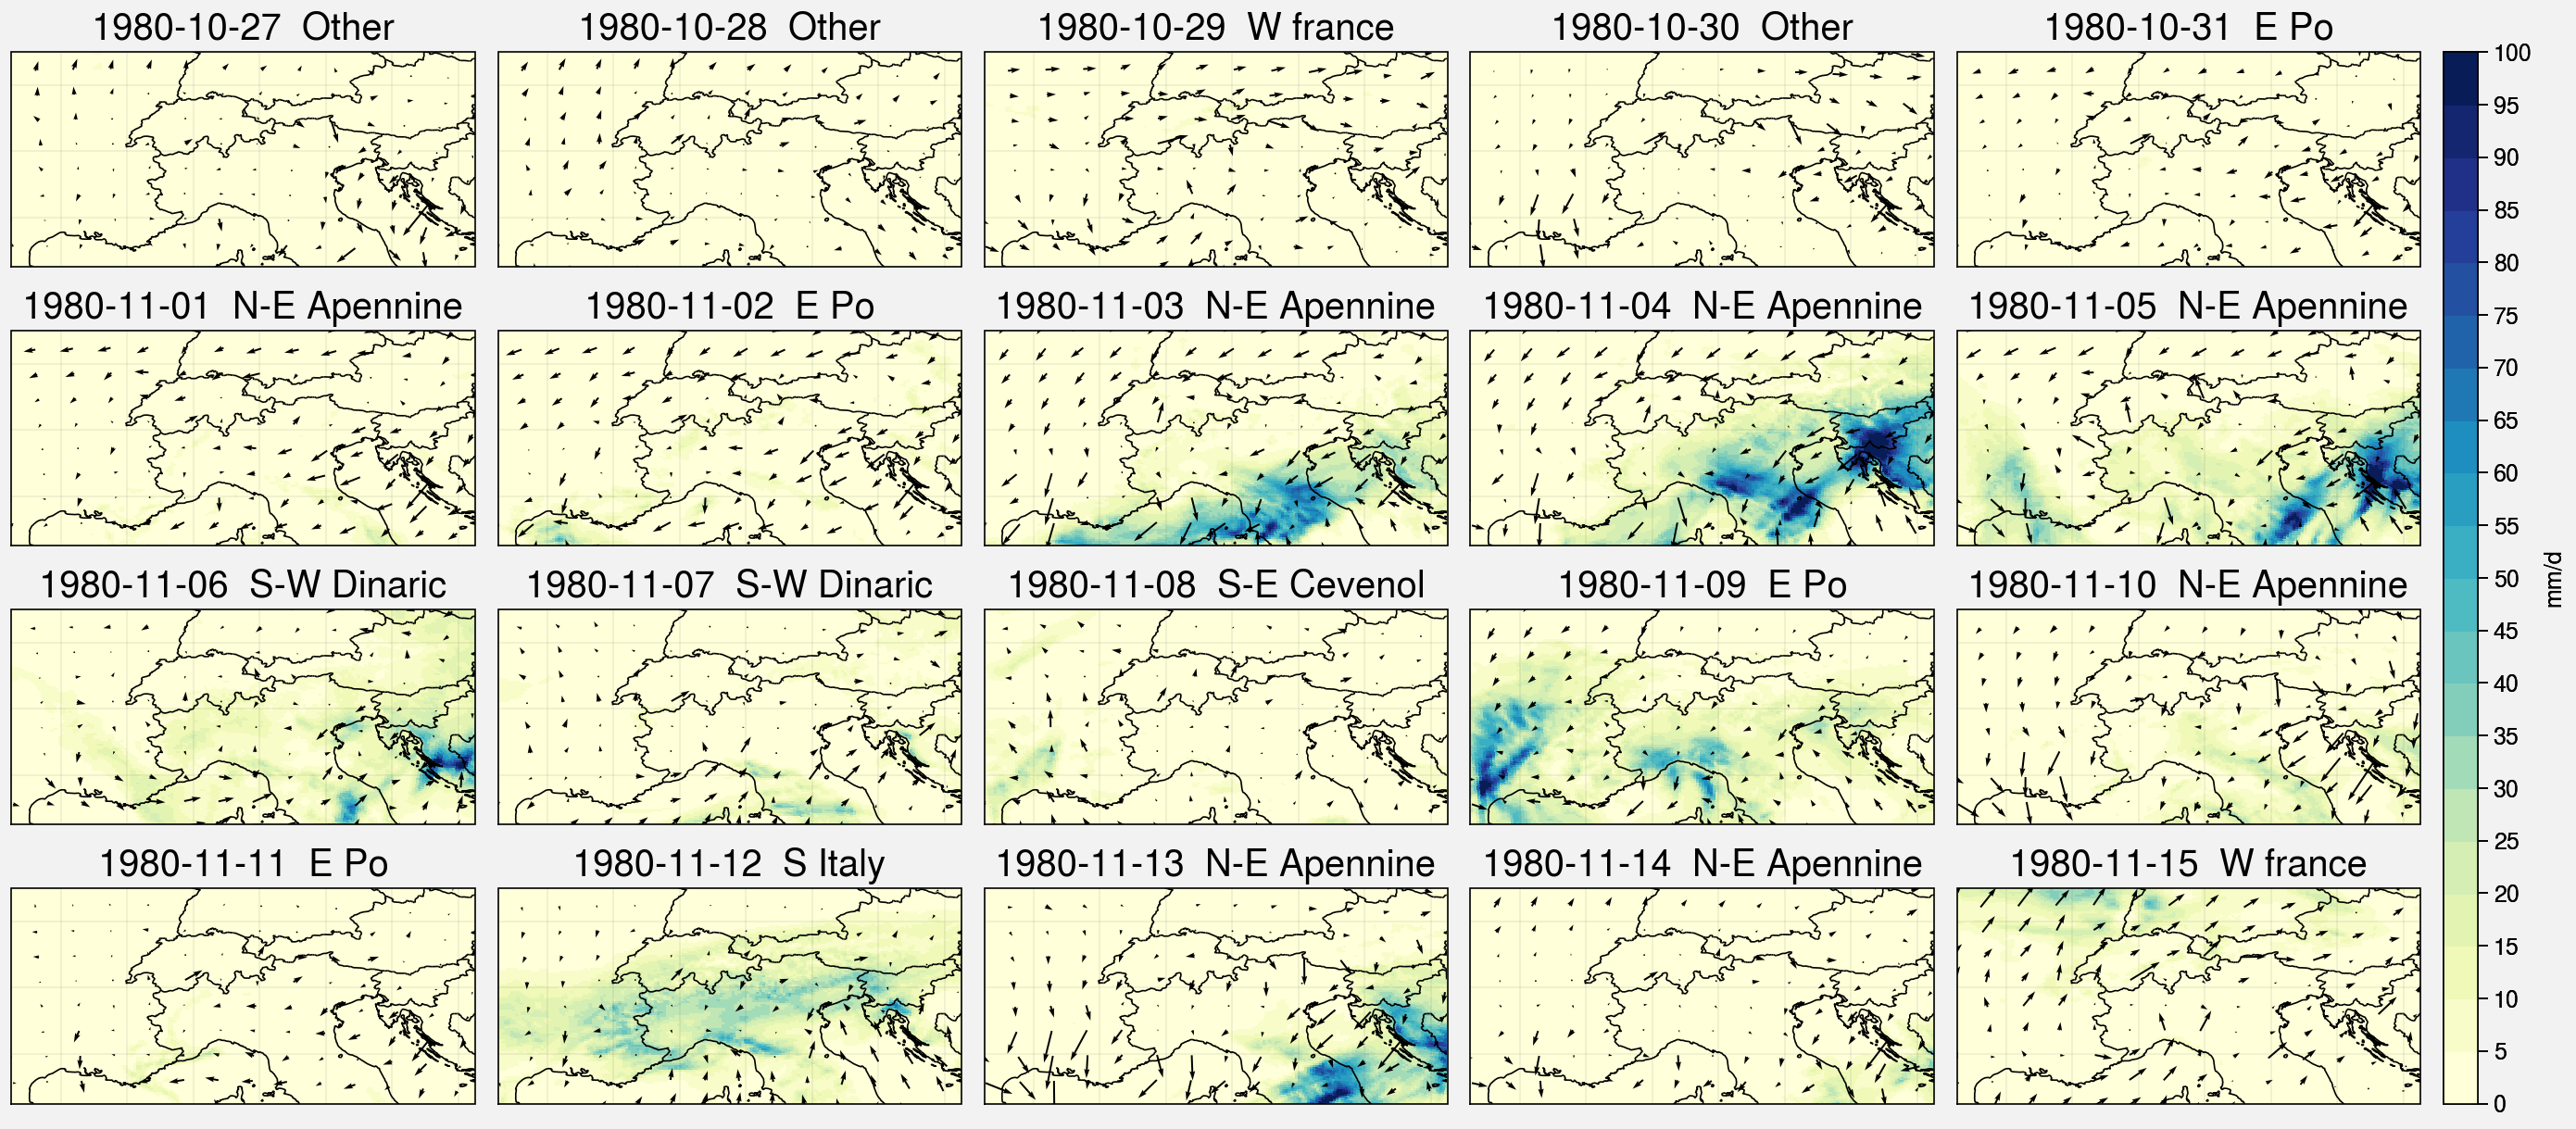

In [50]:
f, axs = pplt.subplots(proj='cyl',ncols=5, nrows=4)
for ax,i in enumerate(range(300,320)):
    cb_prec=axs[ax].pcolormesh(lon_,lat_,P[i],levels=np.linspace(0,100,21),cmap='YlGnBu')
    axs[ax].format(title=str(dates.data[i])[:10] +'  '+ ['W france','N swiss','N austria','S-E Cevenol','E Po','N-E Apennine','S france','S Italy','S-W Dinaric','Other'][classification[i]] ,titlesize='20px')
    step=12
    axs[ax].quiver(lon_[::step,::step],lat_[::step,::step],U[i,::step,::step],V[i,::step,::step],width=0.004,scale=250)
f.colorbar(cb_prec,label= 'mm/d')
axs.format(**EUROCORDEX_format,suptitle='')

In [48]:
freq_season = np.zeros((10,4))
for j,s in enumerate(['DJF','MAM','JJA','SON']):
    freq_season[:,j] = np.array([400*np.mean(np.logical_and(classification==i,dates.dt.season==s)) for i in range(10)])
print(freq_season)

[[18.45619658 12.66025641 11.77884615  9.77564103]
 [ 6.46367521 11.93910256 22.22222222  7.23824786]
 [10.65705128 12.4465812  15.03739316  8.70726496]
 [ 7.02457265  4.13995726  0.66773504  8.49358974]
 [ 3.97970085  5.23504274  3.1784188   5.76923077]
 [11.45833333 10.71047009 10.68376068 12.60683761]
 [ 5.04807692  7.45192308  6.46367521  7.8525641 ]
 [ 5.23504274  6.54380342  5.42200855  7.42521368]
 [ 7.8258547   8.76068376 12.39316239 11.05769231]
 [22.70299145 20.86004274 12.90064103 20.72649573]]


In [22]:
freq_season = np.zeros((11,4))
for j,s in enumerate(['DJF','MAM','JJA','SON']):
    freq_season[:,j] = np.array([400*np.mean(np.logical_and(classification==i,dates.dt.season==s)) for i in range(10)])
print(freq_season)

[[30.91910477 19.92932412 12.7598612  17.14049218]
 [ 5.31024164 11.77931298 19.75104263  5.56492948]
 [11.47368756 14.08423801 14.21158193  8.57024609]
 [ 5.81961733  4.15141193  1.10789214  7.27133807]
 [ 2.99258222  5.08102257  3.92219286  4.6989908 ]
 [ 7.69157302  7.62790105  8.44290217 10.70962402]
 [ 8.58298048 10.62048327  8.3919646   8.91407469]
 [ 6.53274331  6.31625864  4.03680239  6.64735284]
 [ 7.19493171  7.72977619 10.45493617  9.5635287 ]
 [ 1.48992391  2.43226895  6.58368088  5.08102257]
 [10.82423355 11.00251504 11.09165579 15.49775556]]


In [23]:
np.mean(freq_season,1)

array([20.18719557, 10.60138168, 12.0849384 ,  4.58756487,  4.17369711,
        8.61800006,  9.12737576,  5.88328929,  8.73579319,  3.89672408,
       12.10403999])

In [19]:
np.save('/home/philinat/Stage-M2/saved_clustering/freq_season_MPI_HIST.npy',freq_season)

In [20]:
freq_season_HIST = np.load('/home/philinat/Stage-M2/saved_clustering/freq_season_MPI_HIST.npy')